In [1]:
import torch


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import re

city_newsletter_re=re.compile(r'([A-Za-z\s]+)?\/?([A-Z\s]+)?(,?\s[A-za-z]+.+\s)?\(Reuters\)')
html_re=re.compile(r'<[^>]+>|&amp;|&lt;|&gt;|&nbsp;')
links_re=re.compile(r'http[s]?:\/\/\S+')
date_re=re.compile(r'(\b(January|February|March|April|May|June|July|August|September|October|November|December)\b\s\d{1,2},\s\d{4})',re.IGNORECASE)
username_re=re.compile(r'@\w+')
image_reference=re.compile(r'(Featured|Photo\sby|Image)[\w\/\s]+',re.IGNORECASE)
hashtag=re.compile(r'#\w+')

def preprocess_data_fake_news(text):
    text=date_re.sub('[DATE]',text)
    text=image_reference.sub(' ',text)
    text=html_re.sub(' ',text)
    text=username_re.sub('[USERNAME]',text)
    text=links_re.sub('[LINK]',text)
    text=hashtag.sub('[HASHTAG]',text)
    text=re.sub(r'\s+', ' ', text)
    return text

def preprocess_data_true_news(text):
    text=city_newsletter_re.sub(' ',text, count=1)
    text=re.sub(r'\s+', ' ', text)
    return text

In [3]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

df_fake= pd.read_csv("../data/Fake.csv")
df_true= pd.read_csv("../data/True.csv")

df_fake["label"] = 0
df_true["label"] = 1

In [4]:
df_fake['text'] = df_fake['text'].progress_apply(preprocess_data_fake_news)
df_true['text'] = df_true['text'].progress_apply(preprocess_data_true_news)

100%|██████████| 21417/21417 [06:04<00:00, 58.73it/s]  


In [5]:
import pandas as pd
from datasets import DatasetDict, Dataset

frames=[df_true,df_fake]
df=pd.concat(frames)
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df = shuffled_df.drop_duplicates()
shuffled_selected = shuffled_df[['text', 'label']]

news_text=shuffled_selected
train_frac = 0.7
valid_frac = 0.15
test_frac = 0.15
#
train_size = int(train_frac * len(news_text))
valid_size = int(valid_frac * len(news_text))
#
# create train, validation, and test datasets
train_df = news_text[:train_size]
valid_df = news_text[train_size:train_size + valid_size]
test_df = news_text[train_size + valid_size:]
#
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds = Dataset.from_pandas(test_df)
dataset_dict = DatasetDict({
    'train': train_ds,
    'validation': valid_ds,
    'test': test_ds
})


print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 31280
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 6703
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 6704
    })
})


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path="google-bert/bert-base-uncased"
#incarcam tokenizatorul
tokenizer=AutoTokenizer.from_pretrained(model_path)
#stabil id-urile pentru ca atunci cand primim rezultate de la clasificator acestea sa nu vina sub forma unor probabilitati si sa nu stim carei probabilitate ii vine id ul
id2label={0:"fake",1:"true"}
label2id={"fake":0,"true":1}
#incarcam modelul preantrenat
model=AutoModelForSequenceClassification.from_pretrained(model_path,num_labels=2,id2label=id2label,label2id=label2id)

D:\github\AI-examples\AI_examples\.venv\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#inghetam parametrii de pe celelalte layere si ii pastram doar pe cei de pe layerul 
for name,param in model.base_model.named_parameters():
    param.requires_grad=False
for name,param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad=True

In [8]:
from transformers import DataCollatorWithPadding
def preprocess_function(examples):
    return tokenizer(
        examples["text"], 
        truncation=True,  
        padding="max_length",  
        max_length=512  
    )

tokenized_data=dataset_dict.map(preprocess_function,batched=True)
data_colator= DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/31280 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/6704 [00:00<?, ? examples/s]

In [9]:
import evaluate
import numpy as np
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred

    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)

    # use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]

    # compute auc
    auc = np.round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'], 3)

    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)

    # compute accuracy
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'], 3)

    return {"Accuracy": acc, "AUC": auc}

In [10]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="bert_training_model_fake_news_detection",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=400,
    logging_dir="./logs",
    report_to="none" 
)

In [11]:
import torch
print(torch.cuda.get_device_name(0))  # If no GPU, this will raise an error


NVIDIA GeForce RTX 3050 Laptop GPU


In [12]:
from transformers import Trainer
from transformers import EarlyStoppingCallback
import torch

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2
)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_colator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.090000,0.091879,0.971000,0.994000
2,0.060700,0.075503,0.978000,0.997000
3,0.064600,0.063877,0.982000,0.998000
4,0.060700,0.062288,0.981000,0.998000
5,0.064700,0.058946,0.983000,0.998000


TrainOutput(global_step=19550, training_loss=0.0880912381730726, metrics={'train_runtime': 7546.7169, 'train_samples_per_second': 20.724, 'train_steps_per_second': 2.591, 'total_flos': 4.1150569058304e+16, 'train_loss': 0.0880912381730726, 'epoch': 5.0})

In [13]:
predictions=trainer.predict(tokenized_data["test"])

logits=predictions.predictions
labels=predictions.label_ids
metrics=compute_metrics((logits,labels))
print(metrics)

{'Accuracy': np.float64(0.981), 'AUC': np.float64(0.998)}


In [14]:
model.save_pretrained("./bert_model_final_fake_news_detection")
tokenizer.save_pretrained("./bert_model_final_fake_news_detection")


('./bert_model_final_fake_news_detection\\tokenizer_config.json',
 './bert_model_final_fake_news_detection\\special_tokens_map.json',
 './bert_model_final_fake_news_detection\\vocab.txt',
 './bert_model_final_fake_news_detection\\added_tokens.json',
 './bert_model_final_fake_news_detection\\tokenizer.json')

In [15]:
dataset_dict.save_to_disk("./my_news_dataset_final_fake_news_detection")

Saving the dataset (0/1 shards):   0%|          | 0/31280 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6703 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6704 [00:00<?, ? examples/s]

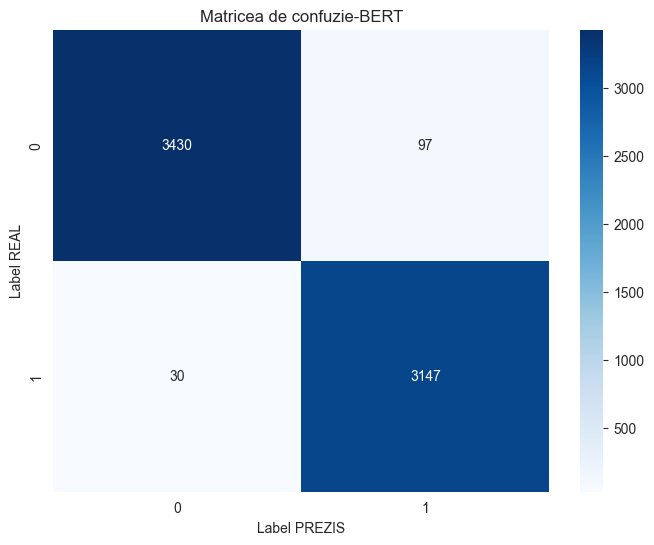

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = labels
y_pred = np.argmax(logits, axis=1)

cm = confusion_matrix(y_true, y_pred)
class_labels = np.unique(y_true)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matricea de confuzie-BERT')
plt.xlabel('Label PREZIS')
plt.ylabel('Label REAL')
plt.show()
